In [1]:
#libraries to download

#%pip install matplotlib
#%pip install geojson
#%pip install folium



In [21]:
#imports

import requests
from bs4 import BeautifulSoup
import random
import json
import re
import folium
import geojson
from IPython.display import display
import matplotlib.pyplot as plt
import unidecode



In [3]:
#headers to get html_content
HEADERS = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:98.0) Gecko/20100101 Firefox/98.0",
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
        "Accept-Language": "en-US,en;q=0.5",
        "Accept-Encoding": "gzip, deflate",
        "Connection": "keep-alive",
        "Upgrade-Insecure-Requests": "1",
        "Sec-Fetch-Dest": "document",
        "Sec-Fetch-Mode": "navigate",
        "Sec-Fetch-Site": "none",
        "Sec-Fetch-User": "?1",
        "Cache-Control": "max-age=0",
    }


In [40]:
def get_data_from_page(url):
    r = requests.get(url,headers=HEADERS)
    html_content = r.text
    soup = BeautifulSoup(html_content, 'html.parser')
    return soup

def scrape_prices_and_districts(url, max_pages):
    prices_for_each_district = {}
    for page_num in range(1, max_pages+1):
        url_with_page = f"{url}&page={page_num}"
        soup = get_data_from_page(url_with_page)
        if soup:
            prices = soup.find_all('span', class_='css-1uwck7i e1a3ad6s0')
            streets = soup.find_all('p', class_='css-1dvtw4c e12u5vlm0')
            for price, street in zip(prices, streets):
                price_text = price.get_text()
                matches = re.findall(r'\d+', price_text)
                if matches:
                    price_value = int(''.join(matches))
                    district = street.text.strip().split(',')[-3].strip()
                    if district in prices_for_each_district:
                        prices_for_each_district[district].append(price_value)
                    else:
                        prices_for_each_district[district] = [price_value]
                    
        else:
            print("Skipped this page:", page_num)
    return prices_for_each_district
            
  
       
url = "https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/malopolskie/krakow/krakow/krakow?viewType=listing&limit=72&page=2"
pages = 5


def average_prices_for_each_district(url, max_pages):
    result = scrape_prices_and_districts(url, max_pages)
    average_arr = []
    districts = []
    for district in result:
        average = sum(result[district]) / len(result[district])
        districts.append(district)
        average_arr.append(average)
        #print(f"{district} {average}")
    return average_arr, districts





with open('krakow-dzielnice.geojson', 'r', encoding='utf-8') as f:
    geo_data = json.load(f)

average_prices_for_each_district(url, 1)  

m = folium.Map(location=[50.0647, 19.9450], zoom_start=12)
folium.Marker(location=[50.0647, 19.9450], popup="Przykładowy tekst").add_to(m)

folium.GeoJson(geo_data,
    style_function=lambda feature: {
        "fillColor": "#ffff00",
        "color": "black",
        "weight": 2,
        "dashArray": "5, 5",
    },).add_to(m)


display(m)

Swoszowice 149000.0
Podgórze Duchackie 555000.0
Prądnik Czerwony 829466.6666666666
Prądnik Biały 830590.8571428572
Podgórze 1221879.642857143
Bieżanów-Prokocim 700377.3333333334
Stare Miasto 782500.0
Nowa Huta 460865.71428571426
Dębniki 956504.0
Mistrzejowice 941562.0
Bieńczyce 567000.0
Krowodrza 1514500.0
Czyżyny 914000.0
Bronowice 634500.0


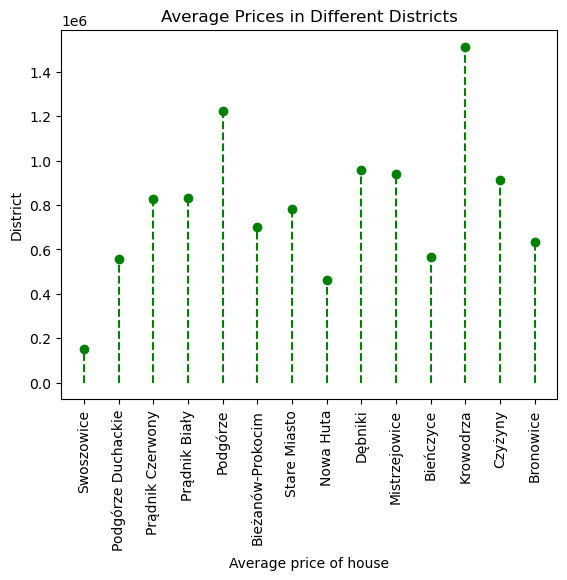

In [5]:
average_prices, districts = average_prices_for_each_district(url, 1)
plt.stem(districts, average_prices, linefmt='g--', markerfmt='go', basefmt=' ')
plt.xlabel('Average price of house')
plt.ylabel('District')
plt.xticks(rotation=90)
plt.title('Average Prices in Different Districts')
plt.show()

In [37]:
def get_prices_per_meter(url, max_pages):
    price_list = []
    districts = []
    for page_num in range(1, max_pages + 1):
        url_with_page = f"{url}&page={page_num}"
        soup = get_data_from_page(url_with_page)
        prices = soup.find_all(class_='css-1c1kq07 e12r8p6s0')
        streets = soup.find_all('p', class_='css-1dvtw4c e12u5vlm0')
        for price, street in zip(prices, streets):
            district = street.text.strip().split(',')[-3].strip()
            price_pattern = r'Cena za metr kwadratowy([\d\s]+)zł/m²'
            price_match = re.search(price_pattern, price.get_text())
            if price_match:
                price_to_print = price_match.group(1)
                clean_price = unidecode.unidecode(price_to_print)
                price_list.append(float(clean_price.replace(" ", "")))
                districts.append(district)
                #print(price_to_print + "" + district)
            else:
                continue
    return districts, price_list


def average_prices_for_each_district_per_meter(url, max_pages):
    districts, price_list = get_prices_per_meter(url, max_pages)
    average_arr = []
    unique_districts = list(set(districts))  
    for district in unique_districts:
        prices_for_district = [price_list[i] for i in range(len(districts)) if districts[i] == district]
        average = sum(prices_for_district) / len(prices_for_district)
        average_arr.append(average)
        #print(f"{district} {average}")
        
    return average_arr, unique_districts
    
    
    

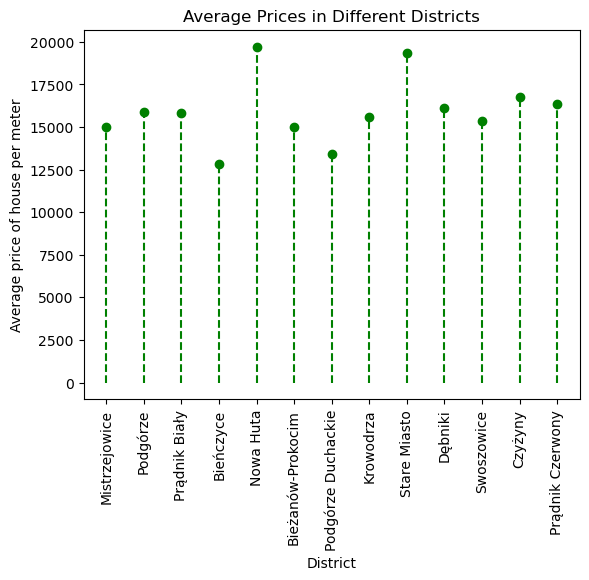

In [38]:
url = "https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/malopolskie/krakow/krakow/krakow?viewType=listing&limit=72&page=2"
districts, prices_per_meter = average_prices_for_each_district_per_meter(url, 3)
plt.stem(prices_per_meter,districts, linefmt='g--', markerfmt='go', basefmt=' ')
plt.xlabel('District')
plt.ylabel('Average price of house per meter')
plt.xticks(rotation=90)
plt.title('Average Prices in Different Districts')
plt.show()